In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime
from kaleido.scopes.plotly import PlotlyScope
import plotly.express as px
import kaleido
rcParams['figure.figsize'] = (17, 10)
sns.set_theme(context='talk', style='whitegrid')

In [2]:
scope = PlotlyScope(
    plotlyjs="https://cdn.plot.ly/plotly-latest.min.js",
    # plotlyjs="/path/to/local/plotly.js",
)

In [3]:
def save_graph(title, fig):
    with open(f'./plots/{title}.png', 'wb') as f:
        f.write(scope.transform(fig, format='png'))

### Daily Data

In [4]:
#
df = pd.read_csv('./tml.csv')

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
twe = df.loc[df['Date'].dt.date < datetime.date(2022, 6, 6)]
twe_com = df.loc[df['Date'].dt.date >= datetime.date(2022, 6, 6)]

In [7]:
title = 'Tweet Count per Daily'
fig = px.bar(df, x='Date', y='count', title=title)
# fig.show()
save_graph(title, fig)

###### Before plotting Timeseries for BTC Close and daily sentiment for Twitter for the period from April 10 to June 19, let's take a look at tweet count per day. We can observe that we have lot more tweets in June, and that's because Twitter api allows to get comments only for past ten day, so I was able to collect comments only for starting June 5

<img src="plots/Tweet Count per Daily.png" width=700 height=400 />

In [8]:
title = 'Timeseries, Daily'
fig = px.line(df, x='Date', y=['Close_adj', 'sentiment_adj'], title=title)
# fig.show()
save_graph(title, fig)

###### Keeping in mind that data collected starting June 5, should be much more accurate that sentiment before that. And indeed in the beginning it looks a little chaotic, but when it approaches the end of the graph it becomes much more accurate.

<img src="plots/Timeseries, Daily.png" width=700 height=400 />

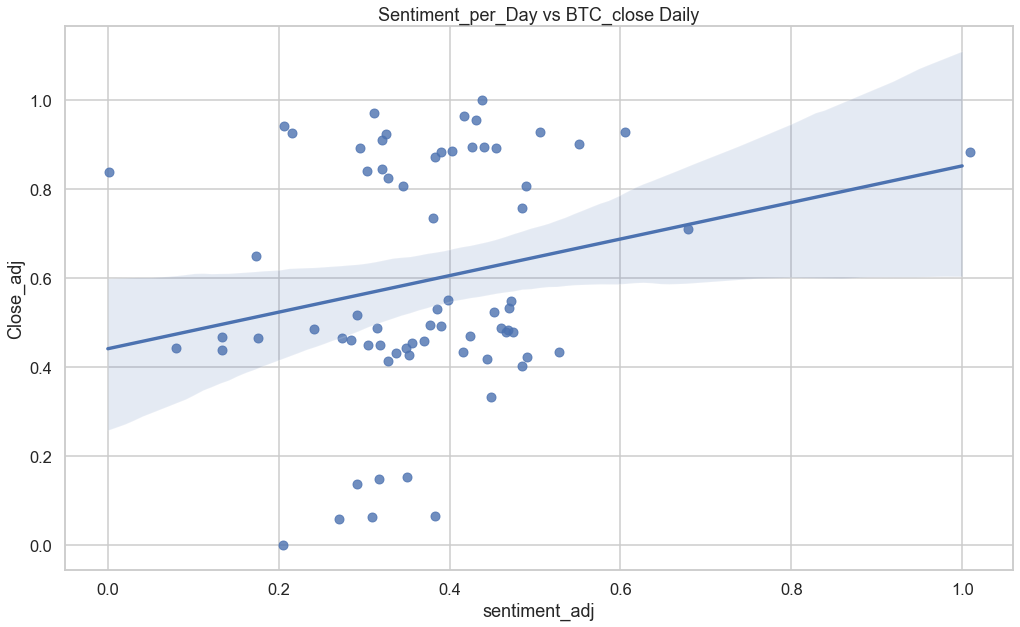

In [9]:
title = 'Sentiment_per_Day vs BTC_close Daily'
sns.regplot(data=df, y='Close_adj', x='sentiment_adj', x_jitter=0.01)
plt.title(title)
save_graph(title, fig)

###### We can see that data is quite chaotic, let's take a look at its correlation

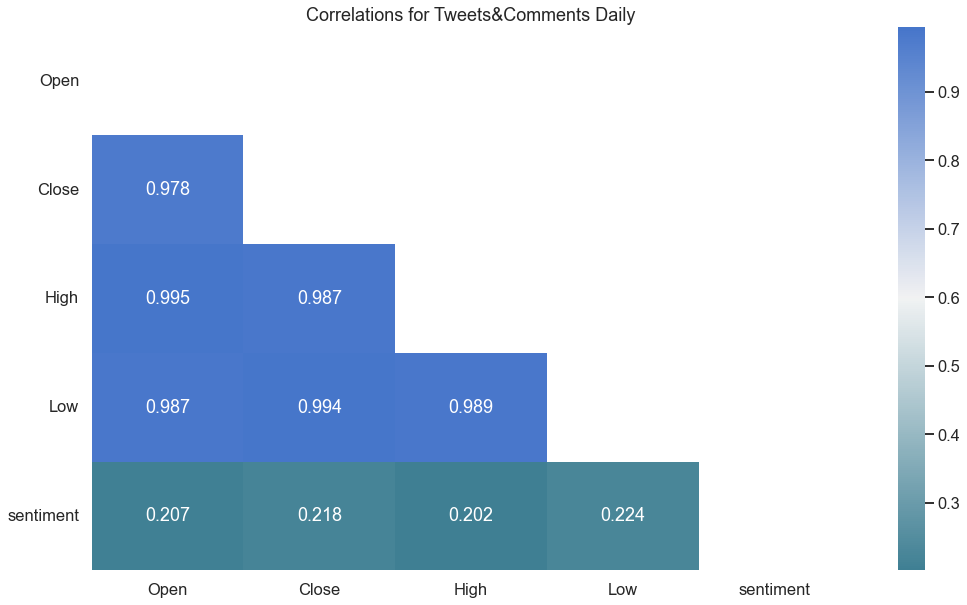

In [10]:
corr = df[['Open', 'Close', 'High', 'Low', 'sentiment']].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 255, as_cmap=True)
sns.heatmap(data=corr, mask=mask, annot=True, cmap=cmap, fmt='.3g')
plt.title('Correlations for Tweets&Comments Daily')
plt.xticks(rotation=-0)
plt.yticks(rotation=-0);

###### We can see that the correlations between [Open, Close, High, Sentiment], and they are is quite low. Now let's plot everything all over again but take into account only the period of time when we have lots of tweets and comments

In [12]:
title = 'Tweet & Comment Count per Daily'
fig = px.bar(twe_com, x='Date', y='count', title=title)
# fig.show()
save_graph(title, fig)

<img src="plots/Tweet & Comment Count per Daily.png" width=700 height=400 />

###### Now we will be using sentiment per day which includes on average 2500 comments per day. And I expect our results to b much more accurate

In [13]:
title = 'Timeseries, Daily Tweets&Comments'
fig = px.line(twe_com, x='Date', y=['Close_adj', 'sentiment_adj'], title=title)
# fig.show()
save_graph(title, fig)

<img src="plots/Timeseries, Daily Tweets&Comments.png" width=700 height=400 />

###### And indeed, we can see that almost every time one line changes direction the other one follows. NOTE: we do not care if lines are close to each other or not, because we are no trying to predict the price, as well as BTC is measured in USD while sentiment is just an index.

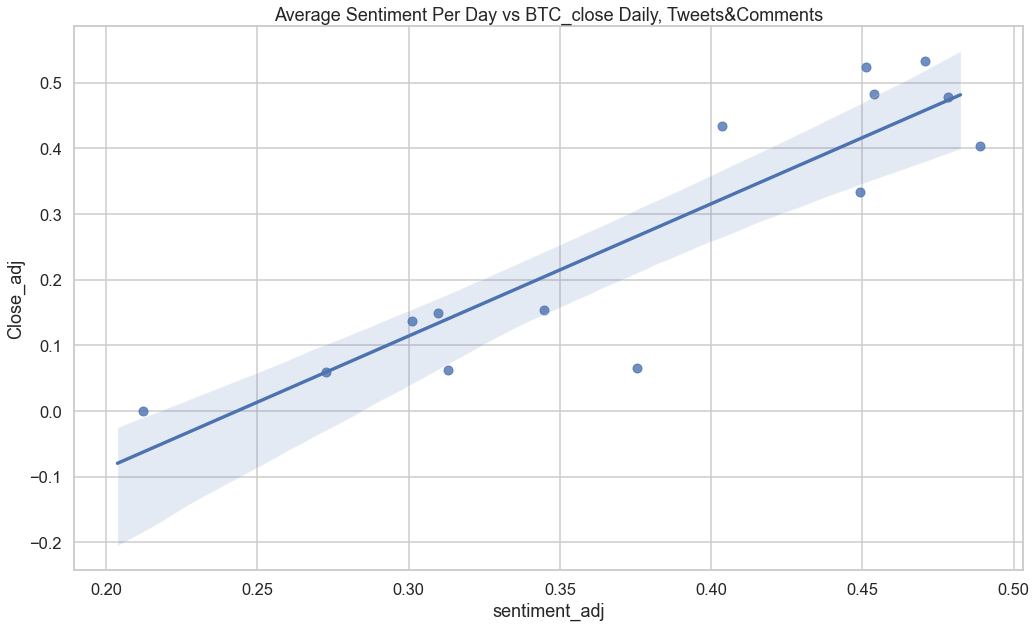

In [14]:
sns.regplot(data=twe_com, y='Close_adj', x='sentiment_adj', x_jitter=0.01)
plt.title('Average Sentiment Per Day vs BTC_close Daily, Tweets&Comments');

###### Here we can observe high linear relationship between two. However, unfortunately, we only have 14 point on the graph which is not statistically significant, but at the same time each point is an average of ~2500 tweets, which makes it much more meaningful.

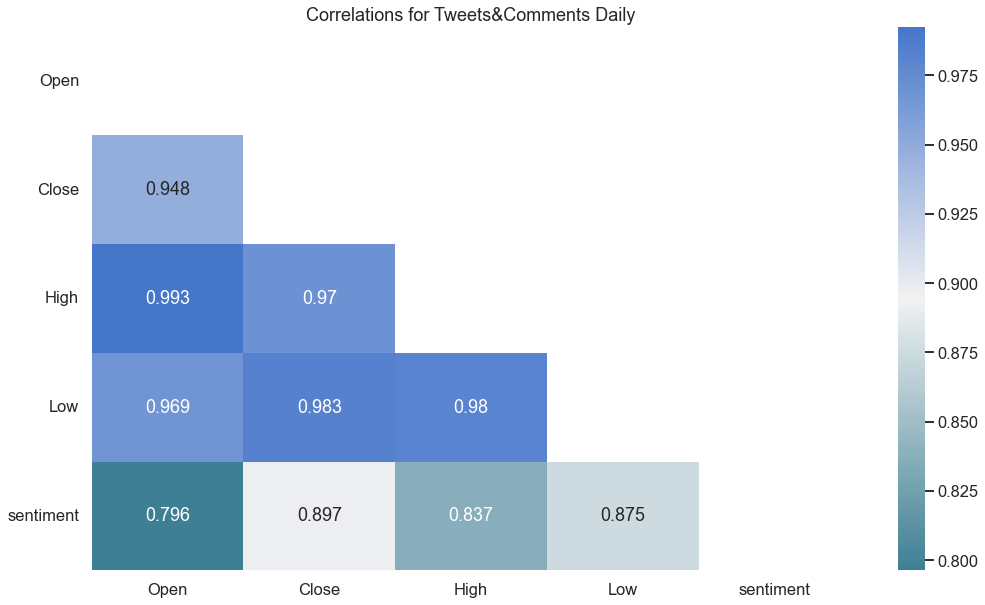

In [15]:
corr = twe_com[['Open', 'Close', 'High', 'Low', 'sentiment']].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 255, as_cmap=True)
sns.heatmap(data=corr, mask=mask, annot=True, cmap=cmap, fmt='.3g')
plt.title('Correlations for Tweets&Comments Daily')
plt.xticks(rotation=-0)
plt.yticks(rotation=-0);

###### Our correlation heatmap confirms high linear relationship between BTC price and the sentiment per day.

### Hourly Data
###### Now let's see how our data will react if we will be taking average per hour rather than per day. Again, this will decrease number of tweets&comments per hour.

In [16]:
hourly_btc = pd.read_csv('btc_hourly.csv')
hourly_sent = pd.read_csv('hourly_sentiment.csv')
hourly_btc['time'] = pd.to_datetime(hourly_btc['time'])
hourly_sent.columns = ['tweet_created', 'avg_sentiment', 'tweet_count']

In [17]:
hourly_btc = hourly_btc.loc[(hourly_btc['time'] >= datetime.datetime(year=2022, month=6, day=6, hour=0)) & (hourly_btc['time'] <= datetime.datetime(year=2022, month=6, day=19, hour=23))]
hourly_sent['tweet_created'] = pd.to_datetime(hourly_sent['tweet_created'], format='%y-%m-%d-%H')

In [18]:
hourly = pd.merge(hourly_btc, hourly_sent, left_on='time', right_on='tweet_created', how='left')

In [19]:
scaler = MinMaxScaler()
hourly[['open_adj', 'close_adj', 'high_adj', 'low_adj', 'sentiment_compound_adj']] = scaler.fit_transform(hourly[['open', 'close', 'high', 'low', 'avg_sentiment']])

In [20]:
hourly.head()

,time,high,low,open,volume_from,volume_to,close,tweet_created,avg_sentiment,tweet_count,open_adj,close_adj,high_adj,low_adj,sentiment_compound_adj
0,2022-06-06 00:00:00,31321.54,31130.49,31233.98,1042.13,32529497.97,31201.09,2022-06-06 00:00:00,0.032414,21.0,0.979084,0.976690,0.969340,0.980194,0.226215
1,2022-06-06 01:00:00,31257.56,31135.47,31201.09,750.20,23400003.60,31147.72,2022-06-06 01:00:00,0.131633,57.0,0.976690,0.972804,0.964656,0.980555,0.376364
2,2022-06-06 02:00:00,31402.97,31133.88,31147.72,971.37,30361323.34,31259.33,2022-06-06 02:00:00,0.086288,41.0,0.972804,0.980930,0.975303,0.980440,0.307743
3,2022-06-06 03:00:00,31361.53,31183.45,31259.33,955.29,29859073.87,31276.23,2022-06-06 03:00:00,0.158283,41.0,0.980930,0.982160,0.972268,0.984031,0.416694
4,2022-06-06 04:00:00,31449.69,31266.13,31276.23,1194.44,37475356.05,31448.98,2022-06-06 04:00:00,0.157592,39.0,0.982160,0.994737,0.978723,0.990021,0.415648


In [21]:
title = 'Tweet Count per Hour'
fig = px.bar(hourly, x='tweet_created', y='tweet_count', title='Tweet Count per Hour')
# fig.show()
save_graph(title, fig)

<img src="plots/Tweet Count per Hour.png" width=700 height=400 />

###### We can observe daily seasonality. Which is quite expected especially since the accounts that we were scraping tweets from are US located. Some hours are completely missing, the other hours have a little of comments and most of them have just over a 100, which looks quite familiar to the first graph when we were plotting tweet counts for the first month. Such seasonality is not very promising, but let's see

In [22]:
title = 'Timeseries, Hourly'
fig = px.line(hourly, x='time', y=['close_adj', 'sentiment_compound_adj'], title=title)
save_graph(title, fig)
# fig.show()

<img src="plots/Timeseries, Hourly.png" width=700 height=400 />

###### First thing that we see is very high volatility of the sentiment and this could be explained by the low number of tweets per point. Let's plot time series where every sentiment point is at least an average of 80 tweets.

In [23]:
hourly_sig = hourly.loc[hourly['tweet_count'] > 80]

In [24]:
title = 'Timeseries, Hourly where count > 80'
fig = px.line(hourly_sig, x='time', y=['close_adj', 'sentiment_compound_adj'], title=title)
# fig.show()
save_graph(title, fig)

<img src="plots/Timeseries, Hourly where count > 80.png" width=700 height=400 />

###### Here we can see some similar behaviour of two graphs, but it is not very clear if there is an actual relationship between two. Let's take a look at the regression plots.

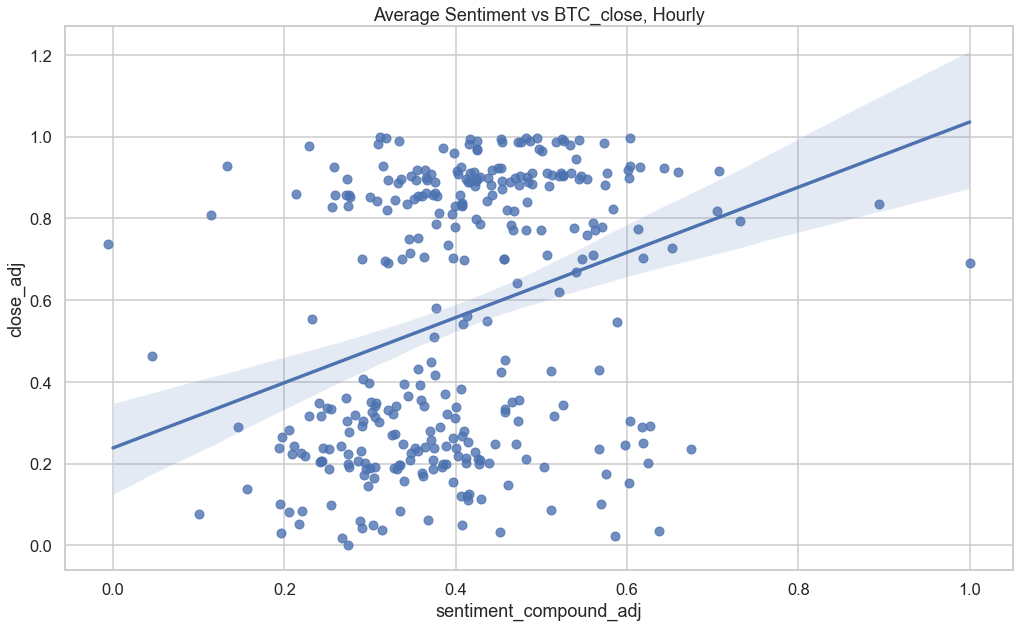

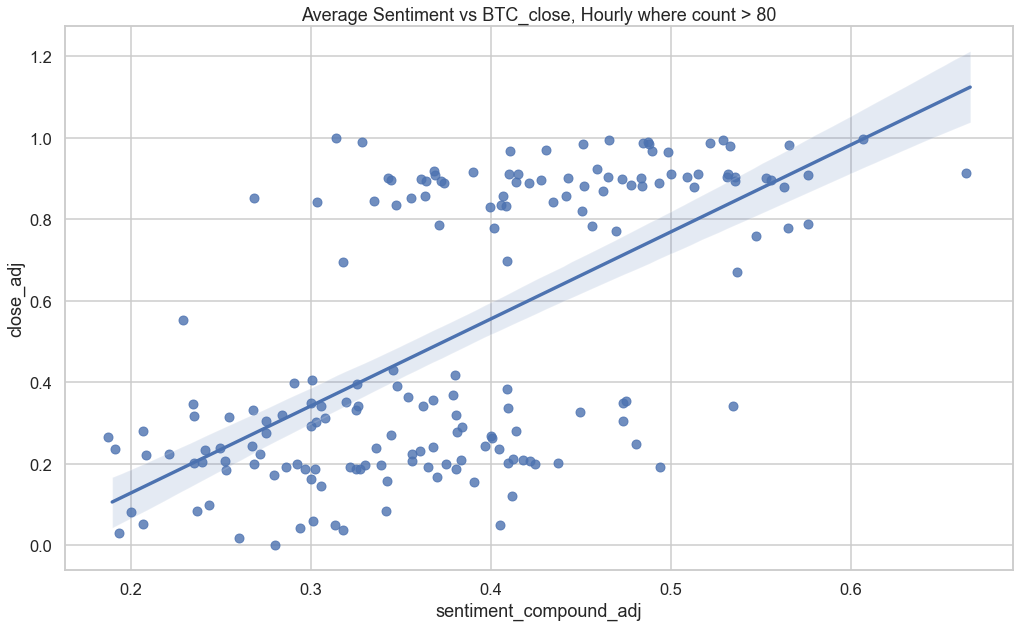

In [25]:
sns.regplot(data=hourly, y='close_adj', x='sentiment_compound_adj', x_jitter=0.01)
plt.title('Average Sentiment vs BTC_close, Hourly')
plt.show();
sns.regplot(data=hourly_sig, y='close_adj', x='sentiment_compound_adj', x_jitter=0.01)
plt.title('Average Sentiment vs BTC_close, Hourly where count > 80')
plt.show();

###### For the first graph it is hard to say that there is a linear relationships between two variables. However, fot the second one we can see some kind of relationship. Let's plot corr heatmaps.

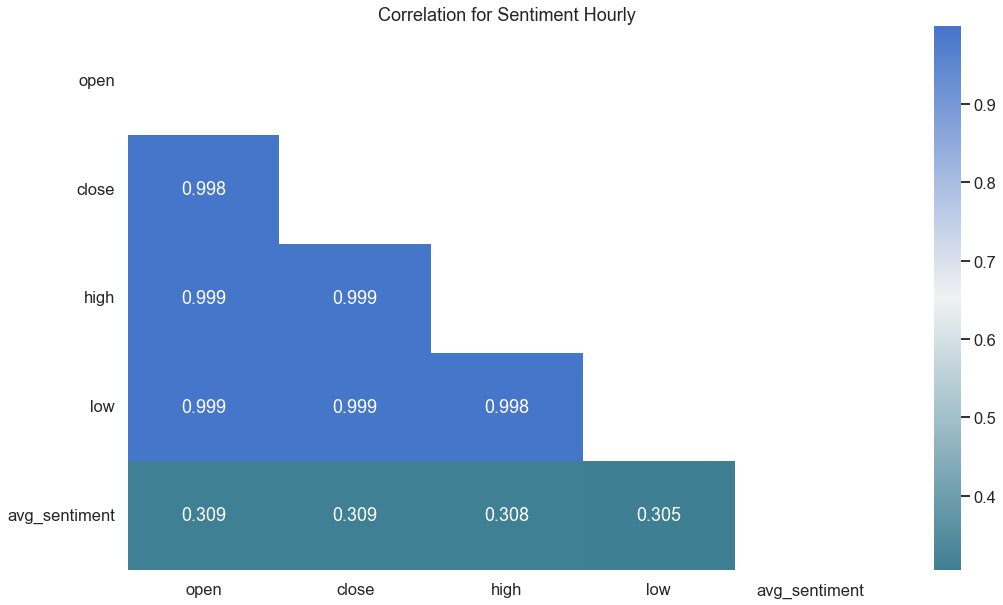

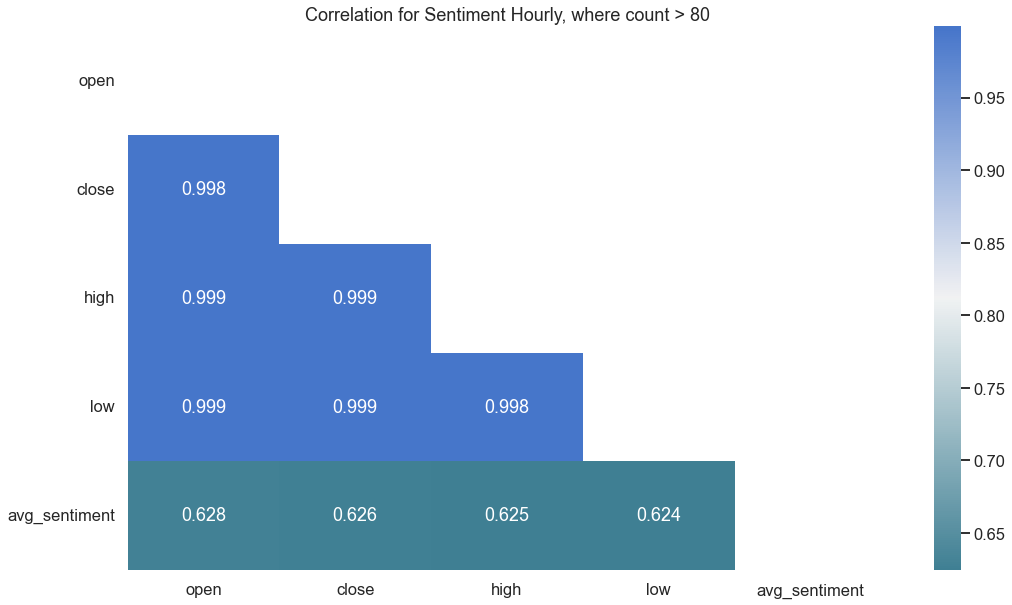

In [26]:
corr = hourly[['open', 'close', 'high', 'low', 'avg_sentiment']].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 255, as_cmap=True)
sns.heatmap(data=corr, mask=mask, annot=True, cmap=cmap, fmt='.3g')
plt.title('Correlation for Sentiment Hourly')
plt.xticks(rotation=-0)
plt.yticks(rotation=-0)
plt.show();
corr = hourly_sig[['open', 'close', 'high', 'low', 'avg_sentiment']].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 255, as_cmap=True)
sns.heatmap(data=corr, mask=mask, annot=True, cmap=cmap, fmt='.3g')
plt.title('Correlation for Sentiment Hourly, where count > 80')
plt.xticks(rotation=-0)
plt.yticks(rotation=-0)
plt.show()

###### We can see that correlation on the first graph is quite low (~0.3), but when we use only sentiment points with at least 80 comments in it, correlation doubles from ~0.3 to 0.63. Which is quite amazing!

### Conclusion
###### What we observed is that if we want to construct our timeseries hourly we need much more data per hour to be extracted. However, if we want to have our timeseries on daily basis, we have plenty of tweets, and their sentiment seems (14 days of data) to be very representative of the market behaviour.